<p style="line-height: 1.1"><font size="24"><b>Parallel programming with R and Azure Batch</b></font></p>

# Embarrasingly Parallel Problems
<br>
Also called **perfectly parallel**, these are the most simple cases for parallel computing: 

- Similar tasks are repeated many times  
    - Iterations in a loop construct, chunks of data  
- Calculations are independent of each other  
- Little or no manipulation needed to create parallel tasks  
- Examples:  
    - Independent Monte Carlo simulations  
    - Analysis by groups of data  
---
Example: Monte Carlo Simulation, random walk of an asset price

In [1]:
getClosingPrice <- function(opening_price=100, mean_change=1.001, volatility=0.01, days=1825) { 
    movement <- rnorm(days, mean = mean_change, sd = volatility) 
    path <- cumprod(c(opening_price, movement)) 
    closingPrice <- path[days] 
    return(closingPrice) 
}

To run multiple independent simulations, we can use one of the many looping constructs that come with R, like `for`, `while` or the `apply` family.  


We use `replicate` to run repeatedly in a single thread: 

Time difference of 15.40491 secs

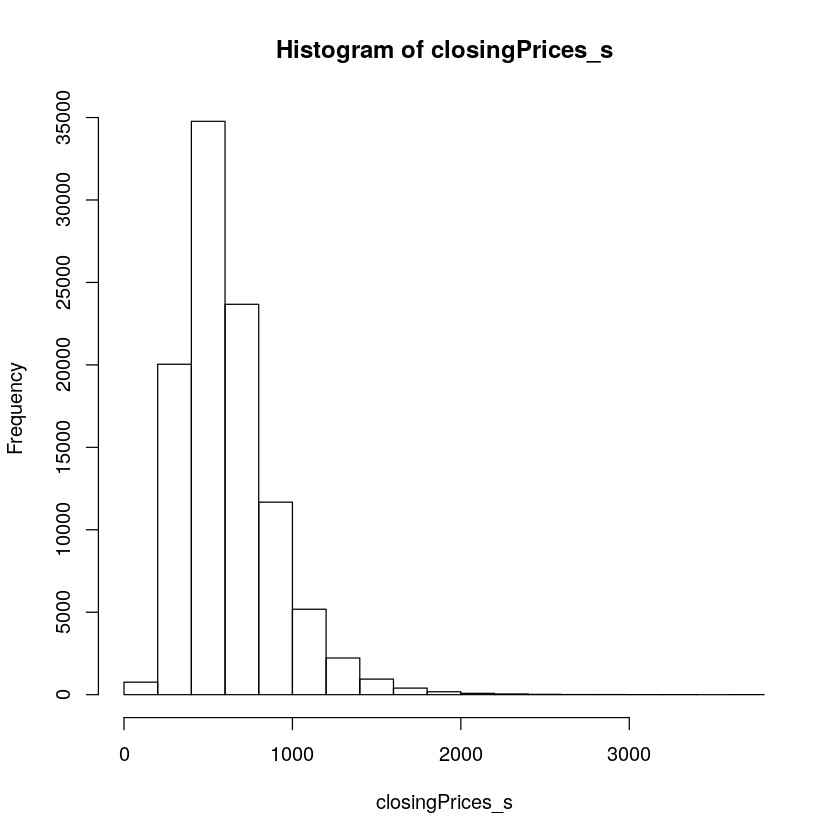

In [2]:
n <- 100000
start_s <- Sys.time() 
closingPrices_s <- replicate(n, getClosingPrice()) 
end_s <- Sys.time()
difftime(end_s, start_s)
hist(closingPrices_s)


# The package `foreach`
## The foreach looping construct

The package [foreach](https://cran.r-project.org/web/packages/foreach/vignettes/foreach.html) introduces a looping construct that supports parallel execution

The `foreach` loop looks similar to a `for` loop, but is implemented using a binary operator, called `%do%`. Unlike `for`, it returns a value



In [3]:
suppressMessages(library(foreach))
foreach(i=1:5) %do% sprintf("Hello from iteration %s", i)

[[1]]
[1] "Hello from iteration 1"

[[2]]
[1] "Hello from iteration 2"

[[3]]
[1] "Hello from iteration 3"

[[4]]
[1] "Hello from iteration 4"

[[5]]
[1] "Hello from iteration 5"

The loop `foreach` with the operator `%do%` runs locally and single threaded, pretty much like `for`. This is essentially used for intermediate local tests.

`foreach` comes with another operator, `%dopar%` that runs iterations in parallel. In order to do so, we need to register a parallel backend

## Registering a parallel backend

There are multiple packages that implement functionality to create and register parallel backend clusters:

- `foreach::registerDoSEQ` explicitly register the default sequential backend
- `doParallel::registerDoParallel` local cluster via library(parallel)
- `doFuture::registerDoFuture` HPC with schedulers
- `future::makeClusterMPI` Message Passing Interface (MPI) cluster
- `doAzureParallel::registerDoAzureParallel`


Example: local cluster with `doParallel`:

Time difference of 7.065464 secs

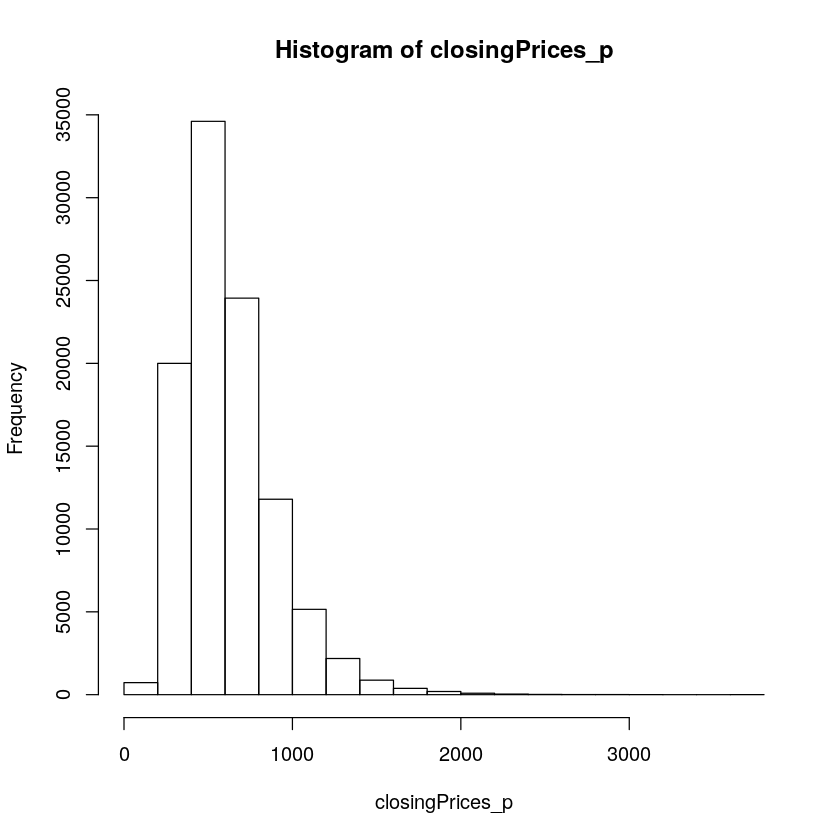

In [4]:
suppressMessages(library(doParallel))
local_cluster <- parallel::makeCluster(4)
registerDoParallel(local_cluster)

n <- 100000
iterations <- 4
start_p <- Sys.time() 
closingPrices_p <- foreach(i = seq(iterations), .combine = "c") %dopar% {
    replicate(n/iterations, getClosingPrice())
}
end_p <- Sys.time()
difftime(end_p, start_p)
hist(closingPrices_p)

# Azure setup
<br>
We will now use the package `doAzureParallel` to interact with an Azure subscription.

You will need to have a valid Azure subscription with access to the resources we will use in this example: an Azure Batch account and a storage account.

First thing is to install the package and its dependency `rAzureBatch`

In [5]:
suppressMessages({
    devtools::install_github("Azure/rAzureBatch", ref = "v0.7.0")
    devtools::install_github("Azure/doAzureParallel", ref = "v0.8.0")
    library(doAzureParallel)
})

## Azure credentials
<br>
Generate a credentials configuration file (template)

In [6]:
generateCredentialsConfig("credentials.json")

<br>
Edit the file with your own Azure credentials:

- Batch account name
- Batch account key: Primary access key
- Batch account URL
- Storage account name
- Storage account key

You find the above in the _Keys_ section of your Batch and Storage accounts in the [Azure portal](https://portal.azure.com/)

<br>
Next, set your credentials in the current R session.

In [7]:
setCredentials("credentials.json")

Batch Account: miraibatch
Batch Account Url: https://miraibatch.northeurope.batch.azure.com
Storage Account: razureinterfaces
Storage Account Url: https://razureinterfaces.blob.core.windows.net
Your credentials have been successfully set.


<br>
If successful, you can see a new option with information of your Azure account.

In [8]:
getOption("az_config")

$sharedKey
$sharedKey$batchAccount
$sharedKey$batchAccount$name
[1] "miraibatch"

$sharedKey$batchAccount$key
[1] "gtsRN0Imh9cBJr6wZQjlBbjpG2P8OKQ0VRQR9ICYs+yxI3svQhjMVij3SQ1NKhF6T1/yGWE9uG5dRId7bKde4g=="

$sharedKey$batchAccount$url
[1] "https://miraibatch.northeurope.batch.azure.com"


$sharedKey$storageAccount
$sharedKey$storageAccount$name
[1] "razureinterfaces"

$sharedKey$storageAccount$key
[1] "nFGg7N7IcXdZArXXLPvj3YLsnZ3J36airmDzraZgbaniaqh9urL7WZqYFduAjYdbV6qkRuZK+ztsk9j80P8GmA=="

$sharedKey$storageAccount$endpointSuffix
[1] "core.windows.net"



$githubAuthenticationToken
[1] ""

$dockerAuthentication
$dockerAuthentication$username
[1] ""

$dockerAuthentication$password
[1] ""

$dockerAuthentication$registry
[1] ""


$applicationInsights
$applicationInsights$applicationId
[1] "RAzureInterfacesDemo"

$applicationInsights$instrumentationKey
[1] "8e2bf19d-b883-4a99-9ef2-a1aecced34d5"


$azureEnvironment
$azureEnvironment$type
[1] "azure"

$azureEnvironment$aadUrl
[1] "https://l

<br>

## Azure Batch pool

<br>
Generate a cluster configuration file (template)

In [9]:
generateClusterConfig("cluster.json")

<br>
Edit the cluster configuration file with your desired configuration.

Create your cluster if it does not exist; this takes a few minutes. Alternatively get your cluster configuration from the Batch account

In [13]:
# Get configuration from Azure
cluster <- getCluster("raipool")
# Create new cluster from configuration file
cluster <- makeCluster("cluster.json") 


nodes:
	idle:                5
	creating:            0
	starting:            0
	waitingforstarttask: 0
	starttaskfailed:     0
	preempted:           0
	running:             0
	other:               0
Your cluster has been registered.
Dedicated Node Count: 5
Low Priority Node Count: 0
Name: raipool
Configuration:
	Docker Image: rocker/tidyverse:latest
	MaxTasksPerNode: 2
	Node Size: Standard_D2_v2
Scale:
	Autoscale Formula: QUEUE
	Dedicated:
		Min: 5
		Max: 5
	Low Priority:
		Min: 0
		Max: 0


Warning message in self$client$extractAzureResponse(response, content):
“Conflict (HTTP 409).”


The specified cluster 'raipool' already exists. Cluster 'raipool' will be used.
Your cluster has been registered.
Dedicated Node Count: 5
Low Priority Node Count: 0


---
Beware of open issue [#330](https://github.com/Azure/doAzureParallel/issues/330) in package `doAzureParallel`. Registering a cluster that has been obtained with `getCluster` results in a not obvious misconfiguration of the cluster. In current version, this issue can be worked around by creating the cluster (again) before registering. That is, running the chunk above. The cluster will in fact not be re-created, but the metadata will be fixed.

---
Finally, register your Azure cluster as the parallel backend for `foreach`

In [14]:
registerDoAzureParallel(cluster)

Check that you the cluster is available

In [15]:
# Number of execution workers currently registered in the doPar backend
getDoParWorkers()
# Hello world
foreach(i=1:5) %dopar% sprintf("Hello World from node %s", i)

[1] 10

Id: job20201007213939
chunkSize: 1
enableCloudCombine: TRUE
errorHandling: stop
wait: TRUE
autoDeleteJob: TRUE
Submitting tasks (5/5)
Submitting merge task. . .
Waiting for tasks to complete. . .
| Progress: 100.00% (5/5) | Running: 0 | Queued: 0 | Completed: 5 | Failed: 0 |
Tasks have completed. Merging results... Completed.


$`1`
[1] "Hello World from node 1"

$`2`
[1] "Hello World from node 2"

$`3`
[1] "Hello World from node 3"

$`4`
[1] "Hello World from node 4"

$`5`
[1] "Hello World from node 5"

# Parallel computing on Azure Batch

## Parallel Random Forest

<br>
Let’s take random forest as an example of an operation that can take a while to execute. Let’s say our inputs are the matrix x, and the factor y:

In [16]:
x <- matrix(runif(500), 100)
y <- gl(2, 50)

Let's create a random forest model with 1000 trees. We will plit up the problem into 5 pieces, with the `ntree` argument set to 200. The package `randomForest` comes with a function called `combine` that combines the resulting `randomForest` objects.

We first run it locally. 

In [17]:
suppressMessages(library(randomForest))
rf <- foreach(ntree = rep(10000, 5), .combine = combine) %do%
    randomForest(x, y, ntree = ntree)
rf


Call:
 randomForest(x = x, y = y, ntree = ntree) 
               Type of random forest: classification
                     Number of trees: 50000
No. of variables tried at each split: 2


<br>
Now lets run the same on the registered parallel backend. What about the package `randomForest`? Is it in the Azure Batch pool?

The following block will throw an error

In [18]:
rf <- foreach(ntree = rep(10000, 5), .combine = combine, .errorhandling = "pass") %dopar%
    randomForest(x, y, ntree = ntree)
rf

Id: job20201007214056
chunkSize: 1
enableCloudCombine: TRUE
errorHandling: pass
wait: TRUE
autoDeleteJob: TRUE
Submitting tasks (5/5)
Submitting merge task. . .
Waiting for tasks to complete. . .
| Progress: 100.00% (5/5) | Running: 0 | Queued: 0 | Completed: 5 | Failed: 5 |
Tasks have completed. Merging results... Completed.
error calling combine function:
<simpleError in fun(result.1, result.2): Argument must be a list of randomForest objects>


NULL

## Diagnostics

`doAzureParallel` offers minimum functionality for diagnostics

In [19]:
# Enable verbose mode
setVerbose(TRUE)
setHttpTraffic(TRUE)
rf <- foreach(ntree = rep(200, 5), .combine = combine) %dopar%
    randomForest(x, y, ntree = ntree)
# Disable verbose
setVerbose(FALSE)
setHttpTraffic(FALSE)








Id: job20201007214252
chunkSize: 1
enableCloudCombine: TRUE
errorHandling: stop
wait: TRUE
autoDeleteJob: TRUE


Submitting tasks (1/5)
Submitting tasks (2/5)
Submitting tasks (3/5)
Submitting tasks (4/5)
Submitting tasks (5/5)
Submitting merge task
. . .

Waiting for tasks to complete. . .
| Progress: 100.00% (5/5) | Running: 0 | Queued: 0 | Completed: 5 | Failed: 5 |


Warning message in waitForTasksToComplete(id, jobTimeout, obj$errorHandling):
“5 task(s) failed while running the job. This caused the job to terminate automatically. To disable this behavior and continue on failure, set .errorHandling='remove | pass' in the foreach loop
1
2
3
4
5
”


ERROR: Error in waitForTasksToComplete(id, jobTimeout, obj$errorHandling): Errors have occurred while running the job 'job20201007214252'. Error handling is set to 'stop' and has proceeded to terminate the job. The user will have to handle deleting the job. If this is not the correct behavior, change the errorhandling property to 'pass'  or 'remove' in the foreach object. Use the 'getJobFile' function to obtain the logs. For more information about getting job logs, follow this link: https://github.com/Azure/doAzureParallel/blob/master/docs/90-troubleshooting.md#viewing-files-directly-from-compute-node


Some metadata can be fetched from Azure, but for details of the error we would have to The Azure Portal or Azure Batch explorer.

In [21]:
doAzureParallel::getJob("job20201007214252")

Job Id: job20201007214252

job metadata:
	chunkSize: 1
	enableCloudCombine: TRUE
	packages: 
	errorHandling: stop
	wait: FALSE

tasks:
	active: 0
	running: 0
	completed: 6
		succeeded: 0
		failed: 6
	total: 6

job state: completed


$jobId
[1] "job20201007214252"

$metadata
$metadata$chunkSize
[1] "1"

$metadata$enableCloudCombine
[1] "TRUE"

$metadata$packages
[1] ""

$metadata$errorHandling
[1] "stop"

$metadata$wait
[1] "FALSE"


$tasks
$tasks$active
[1] 0

$tasks$running
[1] 0

$tasks$completed
[1] 6

$tasks$succeeded
[1] 0

$tasks$failed
[1] 6


$jobState
[1] "completed"

The [doAzureParallel troubleshooting documentation in github](https://github.com/Azure/doAzureParallel/blob/master/docs/90-troubleshooting.md) can be helpful. One can also enable verbose logging 


## Monitoring and Managing the Azure environment

`doAzureParallel` offers very limited functionality for monitoring and managing the Azure environment. The Azure Portal or specific tools like Azure Batch Explorer and Azure Storate Explorer (or custom tools using Azure APIs) should be used together for monitoring and management.

Special remark should be made about the status of the Azure Batch cluster. This cannot be changed from the R session with `doAzureParallel`. The cluster nodes are created in status "Enable" (Idle), and thus they are a running cost until they are disabled, or deleted. It is possible to delete a cluster with `doAzureParallel`

# R runtime environment in Azure Batch

## Installing packages for your parallel runs
Our last call to Azure Batch failed because the package `randomForest` was being used, but was not available on the R runtime environment on Azure Batch. It can be installed on the fly using the `foreach` parameter `.packages`

In [ ]:
rf <- foreach(ntree = rep(10000, 10), .combine = combine, .packages = "randomForest") %dopar%
    randomForest(x, y, ntree = ntree)
rf








Id: job20201007214457
chunkSize: 1
enableCloudCombine: TRUE
packages: 
	randomForest; 
errorHandling: stop
wait: TRUE
autoDeleteJob: TRUE


Submitting tasks (1/10)
Submitting tasks (2/10)
Submitting tasks (3/10)
Submitting tasks (4/10)
Submitting tasks (5/10)
Submitting tasks (6/10)
Submitting tasks (7/10)
Submitting tasks (8/10)
Submitting tasks (9/10)
Submitting tasks (10/10)
Submitting merge task
. . .

Job Preparation Status: Package(s) being installed.
Waiting for tasks to complete. . .
| Progress: 100.00% (10/10) | Running: 0 | Queued: 0 | Completed: 10 | Failed: 0 |

Note that every time we execute the above chunk, a new installation of the package `randomForest` is triggered.

## Runtime environment of the `doAzureParallel` cluster
<br>
The R code that we ship to run on the Azure Batch cluster runs on a docker container. This ensures a stable runtime environment: all jobs running on the same node run on a new container. The jobs are independent from each other, thus the past jobs history does not affect new jobs, even if previous jobs did things like installing new packages.

A docker image is specified at the time of creating the cluster, in the file `cluster.json`. The default image is "rocker/tidyverse:latest".

## Customizing the docker image for the R runtime

Installing packages at runtime, like in the last example, is not a convenient practice. Recurrent packages should rather be added to the docker image used for all containers. `doAzureParallel` makes this easy by allowing specification of packages in `cluster.json`. Various sources are allowed: cran, github, bioconductor.

It is also possible to specify a custom container image altogether.

# Accessing the Azure Storage

## Fetching files from the cluster
Lets modify the closing prices example and write on disk results of each iteration

In [ ]:
n <- 100000
iterations <- 10
closingPrices <- foreach(i = seq(iterations), .combine = "c") %dopar% {
    results <- replicate(n/iterations, getClosingPrice())
    results_file <- sprintf("results_iteration_%s.csv", i)
    write.csv(results, results_file, row.names = FALSE)
    return(results)
}
hist(closingPrices)

Now lets download the files generated.  
_To do_

## Mounting Azure File Shares
_To do_

## Distributed computing
_To do_



# References

- [Microsoft Azure Batch documentation](https://docs.microsoft.com/en-us/azure/batch/batch-technical-overview)
- [Package foreach. Vignettes](https://cran.r-project.org/web/packages/foreach/vignettes/foreach.html)
- [Package doParallel. Vignettes](https://cran.r-project.org/web/packages/doParallel/vignettes/gettingstartedParallel.pdf)
- [Package doFuture. Vignettes](https://cran.r-project.org/web/packages/doFuture/vignettes/doFuture.html)
- [Package doAzureFuture. Github repository](https://github.com/Azure/doAzureParallel)
- [Package rAzureBatch. Github repository](https://github.com/Azure/rAzureBatch/tree/master/R)